In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd import Value, Neuron, Layer, MLP


In [3]:
np.random.seed(1337) # Set the seed for NumPy's random number generator to 1337.
                     # This ensures that any random numbers generated by NumPy (e.g using np.random.rand())
                     # will be the same every time running the code, making the results reproducible.

random.seed(1337)    # Set the seed for Python's built-in random number generator to 1337.
                     # this ensures that any random numbers generated by the `random` module (using random.random())
                     # will also be the same every time running the code. 

print(np.random.rand(3))  # Output: [0.26202468 0.15868397 0.27812652]
print(random.random()) 

[0.26202468 0.15868397 0.27812652]
0.6177528569514706


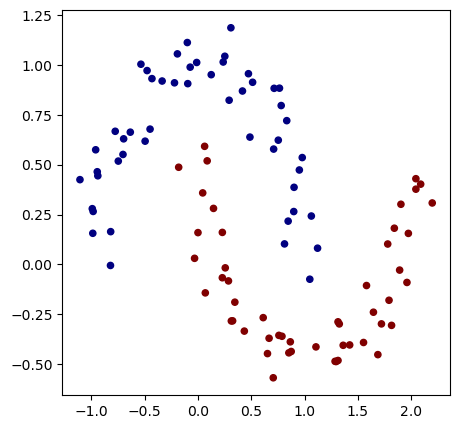

In [4]:
# make up a dataset

# make_moons: Generates a toy dataset shaped like a two interleaving half circles, useful for testing binary classification algorithms.
# make_blobs: Generates isotropic Gausian blobs
from sklearn.datasets import make_moons, make_blobs

# Generate a synthetic dataset with 100 samples and a small amount of noise
# X: a 2D array of shape (100, 2) containing the feature values (coordinates of points)
# y: A 1D array of shape (100, ) containing the labels(0 or 1) for each input
X, y = make_moons(n_samples=100, noise=0.1)  # noise: random variations added to the data to slightly move the data points away from the perfect half-circle shapes,
                                             # making the dataset more realistic and slightly harder to classify

# Transform the labels from [0, 1] to [-1, 1]
# the opeartion converts: 
# - y = 0 becomes -1
# - y = 1 becomes 1
# This is often done for binary classification tasks where the labels need to be -1 and 1
y = y*2 - 1 

# visualize in 2D
# Create a new figure with a size of 5x5 inches
plt.figure(figsize=(5,5))

# Create a scatter plot of the datap points
# X[:, 0]: Extracts the first columm (x-coordinates) from all rows, using NumPy slicing. `:` means "all rows", `0` means "first colum"
# X[:, 1]: Y-coordinates of the points (second column of X)
# c=y: Color of the points based on their labels (y)
# cmap='jet': Use the 'jet' colormap for coloring the points
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [5]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-Layer neurol network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of ['Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2), 'Linear' Neuron(2)], Layer of ['Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16), 'Linear' Neuron(16)], Layer of ['Linear' Neuron(16)]]
number of parameters 337


In [7]:
# Loss function

def loss(batch_size=None):

    # inline Dataloader: prepare a batch of data
    # None is a singleton in Python, meaning there's only one instance of it in memory. 
    # Using `is` is faster and more idiomatic for compareing with None, checking if two objects are the same obj in memory
    if batch_size is None:
        Xb, yb = X, y # Use the entire dataset if no batch size is specified
    else:
        # Step 1: X.shape[0] gives the number of rows (samples) in X. For example, if X.shape = (100, 2), then X.shape[0] = 100.
        # Step 2: np.random.permutation(N) generates a random permutation of integers from 0 to N-1. For example, if X.shape[0] = 100, it generates a shuffled array like [3, 1, 99, 0, 4, ...].
        # Step 3: [:batch_size] slices the shuffled array to select the first batch_size elements. For example, if batch_size = 10, it selects the first 10 indices from the shuffled array.
        # ri: An array of randomly selected indices (e.g., [2, 0]).
        ri = np.random.permutation(X.shape[0])[:batch_size] # Randomly sample `batch_size` indices
        Xb, yb = X[ri], y[ri] # Select the corresponding data points and labels

    # convert input data to `Value` objects for automatic differentiation
    # Iterate over each row in `Xb`.
    # map(Value, xrow) applies the `Value` constructor to each elemtn in xrow. For example, map(Value, [5, 6]) converts [5, 6] to [Value(5), Value(6)]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    # inputs: A list of feature rows, where each row is a list of Value objects (e.g., [[Value(5), Value(6)], [Value(1), Value(2)]]).
    # map(model, inputs): Applies the model function to each row in inputs.
    # For example:
    # model([Value(5), Value(6)]) → Computes the output for the first row.
    # model([Value(1), Value(2)]) → Computes the output for the second row.
    scores = list(map(model, inputs))

    # svm "max-margin" loss: Encoirage correct classification with a margin
    # zip(yb, scores): pairs each true label `yi` with its corresponding model prediction `scorei`.
    # `yi*scorei`: multiplies the true label `yi` by the model's prediction `scorei`.
    # `-yi*scorei`: Negates the result flips the sign: 
    #  - If the model is correct (yi*scorei > 0), then `-`yi*scorei` becomes negative, then 1 + -yi*scorei will be small (close to 0 or negative).
    #  - If the model is wrong (yi*scorei < 0), `yi*scorei` becomes positive, then 1 + -yi*scorei will be large
    losses = [(1 + -yi*scorei).tanh() for yi, scorei in zip(yb, scores)] # Loss for each data point
    data_loss = sum(losses) / len(losses) # Average loss over the batch

    # L2 regularization: Penalize large weights to prevent overfitting
    # Regularization applies to all parameters (weights and biases) to ensure the model generalizes well and avoids overfitting.
    alpha = 1e-4  # Regularization strength that controls the strength of l2 regularization, prevens the model weights from growing too large -> avoid overfitting.
    reg_loss = alpha * sum((p*p for p in model.parameters())) # Sum of squared weights and squared biases
    total_loss = data_loss + reg_loss

    # also get accuracy
    # yi > 0: checks if the true label is positve, e.g, 1 > 0 -> True
    # (yi > 0) == (scorei.data > 0): Compares the true label and the model's prediction, return `True` is they match (correct prediction).
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]

    # In Python, booleans are treated as integers in arithmetic operations. True is 1.
    # E.g accuracy = [True, False, True] --> sum(accuracy) = 1 + 0 + 1 = 2
    print(sum(accuracy))
    
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

67
Value(data=0.4643058752925303) 0.67


In [8]:
# optimization
for k in range(100):
    # forward
    total_loss, acc = loss()

    # backward
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.5*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

67
step 0 loss 0.4643058752925303, accuracy 67.0%
82
step 1 loss 0.30745177257014417, accuracy 82.0%
86
step 2 loss 0.23353561187262342, accuracy 86.0%
85
step 3 loss 0.21143838155516162, accuracy 85.0%
87
step 4 loss 0.19765823187866474, accuracy 87.0%
87
step 5 loss 0.18728391794815086, accuracy 87.0%
87
step 6 loss 0.17924240833876998, accuracy 87.0%
87
step 7 loss 0.172913795462289, accuracy 87.0%
88
step 8 loss 0.16785037097081595, accuracy 88.0%
88
step 9 loss 0.16371943141578693, accuracy 88.0%
88
step 10 loss 0.1602761994224767, accuracy 88.0%
88
step 11 loss 0.15734350789647164, accuracy 88.0%
89
step 12 loss 0.15479569213224562, accuracy 89.0%
89
step 13 loss 0.15254558039197616, accuracy 89.0%
89
step 14 loss 0.1505334216341309, accuracy 89.0%
89
step 15 loss 0.1487176017552, accuracy 89.0%
89
step 16 loss 0.14706774512970983, accuracy 89.0%
89
step 17 loss 0.14556033928581041, accuracy 89.0%
89
step 18 loss 0.14417627385393056, accuracy 89.0%
89
step 19 loss 0.1428995241098

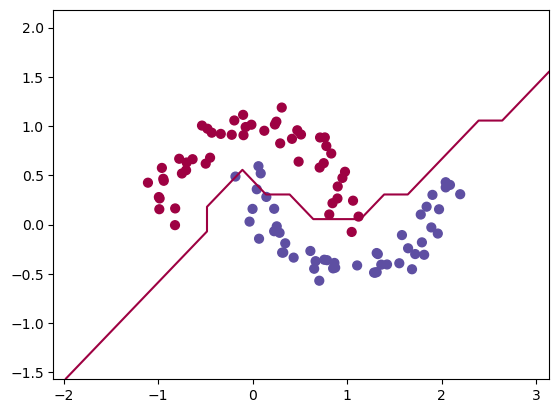

In [9]:
# Visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Fix: Use y_max instead of x_max
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contour(xx, yy, Z, cmap=plt.cm.Spectral, alpha=1.0)  # Fix: Set alpha=1.0
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())  # Fix: Use plt.xlim() instead of plt.slim()
plt.ylim(yy.min(), yy.max())
plt.show()